<a href="https://colab.research.google.com/github/stefanogiagu/corso_AML_2023/blob/main/notebooks/es4/AML_2023_HandsOn_4_ViT_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Machine Learning for Physics 2022-2023
## Hands-on session 4 (Vision Transformers)

In this example, we implement the new trend in image classification for the hadronic jet tagging classification task: Transformers for Computer Vision. 



Task: jet tagging (e.g. classification of jets originating from different particles: *gluons, quarks, Ws, Zs, and top quarks*.

**Physics context:** <p>
At the extreme energies of the Large Hadron Collider, massive particles can be produced with such high Lorentz boost that their decays into hadrons (hadron jets) are collimated in such a way that the resulting particles overlap. Deducing whether the substructure of an observed jet is due to a single low-mass particle or to multiple decay objects of a high-mass particle is an important problem in LHC data analysis. Traditional approaches are based on high-level observables built from theoretical models of energy deposition in calorimeters and charged tracks parameters reconsrtcuted in the inner tracker, but the complexity of the data makes this task an excellent candidate for the application of deep learning tools. The jet constituents can be in fact represented either as 2D or 3D images,lending itself to the natural application of image classification techniques (CNN, ViT etc.), or as pointclouds/graphs, that can be classified with GNNs, or as sequences, that can be analysed by RNNs or Transformers.


**Dataset:** <p>
The dataset is the *JetDataset*, in paricular the dataset that includes jet rapresentation through images.

**Transfortmer Architecture:** <p>

The goal is to implement the original ViT architecture: [Dosovitskiy et al., An Image Is Worth 16X16 Words: Transformers for image recongition at scale](https://arxiv.org/pdf/2010.11929.pdf). 

The implementation is done using pure [PyTorch](https://pytorch.org) APIs.

For infos, latest version of the notebook, etc., contact Stefano Giagu: email: <stefano.giagu@uniroma1.it>, web: [https://www.giagu.it](https://www.giagu.it) 

In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import h5py
import glob

import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

import torch.nn as nn
import torch.nn.functional as F

1.13.1+cu116
0.14.1+cu116


In [2]:
# dataset download
# we'll clone a github repository from M. Pierini containing the dataset
! git clone https://github.com/pierinim/tutorials.git
! ls tutorials/Data/JetDataset/

Cloning into 'tutorials'...
remote: Enumerating objects: 707, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 707 (delta 58), reused 105 (delta 35), pack-reused 579
Receiving objects: 100% (707/707), 566.43 MiB | 18.57 MiB/s, done.
Resolving deltas: 100% (260/260), done.
Updating files: 100% (79/79), done.
jetImage_7_100p_0_10000.h5	jetImage_7_100p_50000_60000.h5
jetImage_7_100p_10000_20000.h5	jetImage_7_100p_60000_70000.h5
jetImage_7_100p_30000_40000.h5	jetImage_7_100p_70000_80000.h5
jetImage_7_100p_40000_50000.h5	jetImage_7_100p_80000_90000.h5


In [2]:
# define device to use (cpu/gpu)
if torch.cuda.is_available():
  print('# of GPUs available: ', torch.cuda.device_count())
  print('First GPU type: ',torch.cuda.get_device_name(0))
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

# of GPUs available:  1
First GPU type:  Tesla T4
Computation device: cuda



## Data Handling

The problem consists in identifying a given jet as a quark, a gluon, a W, a Z, or a top, based on a jet image, i.e., a 2D histogram of the transverse momentum ($p_T$) deposited in each of 100x100 bins of a square window of the ($\eta,\phi$) plane, centered along the jet axis.

The jet images are stored in the 'jetImage' container.

The ground truth is incorporated in a ['j_g', 'j_q', 'j_w', 'j_z', 'j_t] vector of boolean, taking the form:

* $[1, 0, 0, 0, 0]$ for gluons
* $[0, 1, 0, 0, 0]$ for quarks
* $[0, 0, 1, 0, 0]$ for W bosons (with W  qq)
* $[0, 0, 0, 1, 0]$ for Z bosons (with Z  qq)
* $[0, 0, 0, 0, 1]$ for top quarks (with t  Wq  qqq)

This is what is called 'one-hot' encoding of a discrete label (typical of ground truth for classification problems).

In [3]:
# data is stored in hirearchical data format (h5), a file format desgined to store and maniuplate large size data structures
# .h5 files can be accesses in python using the h5py library (https://docs.h5py.org/en/stable/)

# read dataset (only 50k events to keep training time ~20' on google colab, better performance can be obtained adding the three commented files
target = np.array([])
jetImage = np.array([])
datafiles = [#'tutorials/Data/JetDataset/jetImage_7_100p_80000_90000.h5',
             #'tutorials/Data/JetDataset/jetImage_7_100p_70000_80000.h5',
             #'tutorials/Data/JetDataset/jetImage_7_100p_60000_70000.h5',
             #'tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5',
             #'tutorials/Data/JetDataset/jetImage_7_100p_40000_50000.h5',
             'tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5',
             'tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5',
             'tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5']


# let's print what is contained in one of the files:
f = h5py.File(datafiles[0])
print(list(f.keys()))
f.close()

# each file contains different numpy arrays, the ones we are interested in are:
# "jetConstituentsList": containing for each jet, and for each jet constituent particle (up to 100 particles) the 16 features associated to the jet particle
# "jets": containing for each jet several (59) global features of the jet, we are here interested in the elements from -6:-1 that provide a onehot encoding of the jet-type label ['j_g', 'j_q', 'j_w', 'j_z', 'j_t]


#loop over the files and concatenate the content to the p_adat and target arrays
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN) #read the h5 file
    data = np.array(f.get("jetImage")) #jet images
    targ = np.array(f.get('jets')[0:,-6:-1])  #select ['j_g', 'j_q', 'j_w', 'j_z', 'j_t] out of the 59 features presents in the container
    jetImage = np.concatenate([jetImage, data], axis=0) if jetImage.size else data
    target = np.concatenate([target, targ], axis=0) if target.size else targ
    del data, targ
    f.close()

print(target.shape, jetImage.shape)

['jetConstituentList', 'jetFeatureNames', 'jetImage', 'jetImageECAL', 'jetImageHCAL', 'jets', 'particleFeatureNames']
Appending tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5
(30000, 5) (30000, 100, 100)


In [4]:
# print the information for one of the jets

labels = ['gluon', 'quark', 'W', 'Z', 'top']

print('target: ', target[0])
print('so it\'s a jet of type: ',  labels[np.argmax(target[0])])

target:  [1. 0. 0. 0. 0.]
so it's a jet of type:  gluon


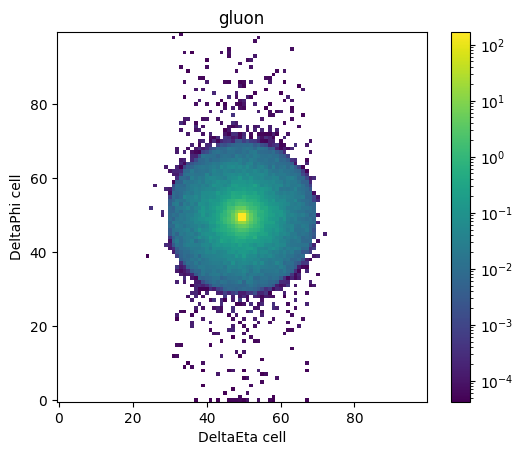

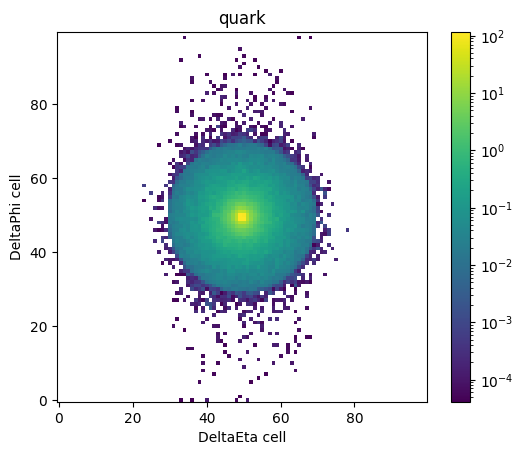

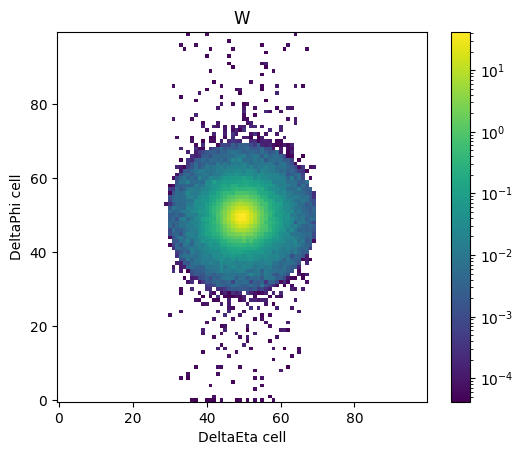

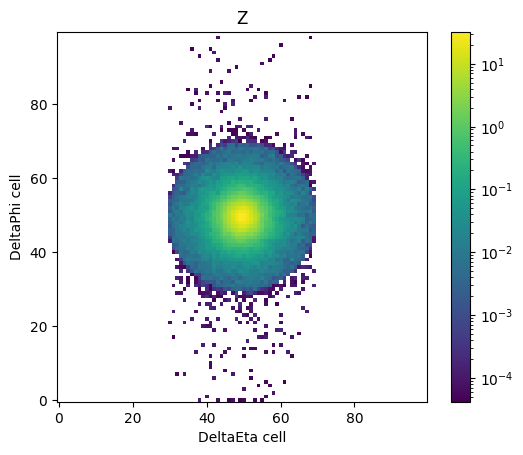

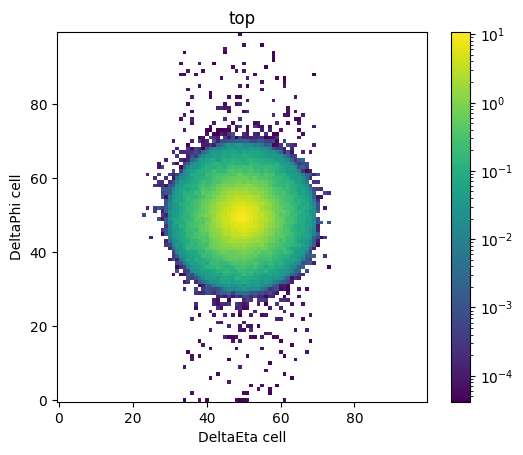

In [5]:
# plots of sum of jet images for different jet catagories 
from matplotlib.colors import LogNorm

image_g = jetImage[np.argmax(target, axis=1) == 0]
image_q = jetImage[np.argmax(target, axis=1) == 1]
image_W = jetImage[np.argmax(target, axis=1) == 2]
image_Z = jetImage[np.argmax(target, axis=1) == 3]
image_t = jetImage[np.argmax(target, axis=1) == 4]
images = [image_q, image_g, image_W, image_Z, image_t]

for i in range(len(images)):
    SUM_Image = np.sum(images[i], axis = 0)
    plt.imshow(SUM_Image/float(images[i].shape[0]), origin='lower',norm=LogNorm())
    plt.colorbar()
    plt.title(labels[i])
    plt.xlabel('DeltaEta cell')
    plt.ylabel('DeltaPhi cell')
    plt.show()

In [6]:
# convert one-hot lables in integers labels, and split data 

p_label = np.argmax(target, axis=1) 

In [9]:
# preprocess data: split on training, validation, test
# normalize fatures (pixels) in [0,1]

from sklearn.preprocessing import MinMaxScaler ,StandardScaler

LOG_BINS = False #represent images in log-bins of intensity if True
Z_SCORE = True #use StandardScaler instaed of MinMaxScaler if True

if Z_SCORE:
  scaler = StandardScaler()
else:
  scaler = MinMaxScaler()

# training, validation, test split
from sklearn.model_selection import train_test_split
testset_frac = 0.2 # test set fraction wrt whole samples
valiset_frac = 0.25 # validation set fraction wrt training+validation

X_train,X_test,Y_train,Y_test = train_test_split(jetImage,p_label,test_size=testset_frac, shuffle=True, random_state=1234)
X_train,X_vali,Y_train,Y_vali = train_test_split(X_train,Y_train,test_size=valiset_frac, shuffle=True, random_state=1234)

X_train = X_train.reshape(X_train.shape[0],100*100)
X_vali = X_vali.reshape(X_vali.shape[0],100*100)
X_test = X_test.reshape(X_test.shape[0],100*100)

if LOG_BINS:
    n_bin = 256
    logbins = np.geomspace(X_train[X_train>0].min(), X_train.max(), n_bin)
    X_train = np.digitize(X_train,logbins)
    X_vali = np.digitize(X_vali,logbins)
    X_test = np.digitize(X_test,logbins)
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_vali = scaler.transform(X_vali)
    X_test = scaler.transform(X_test)

else:
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_vali = scaler.transform(X_vali)
    X_test = scaler.transform(X_test)

    
X_train = X_train.reshape(X_train.shape[0],100,100)
X_vali = X_vali.reshape(X_vali.shape[0],100,100)
X_test = X_test.reshape(X_test.shape[0],100,100)

X_train = np.expand_dims(X_train, -1)
X_vali = np.expand_dims(X_vali, -1)
X_test = np.expand_dims(X_test, -1)

print('X_train shape: ',X_train.shape)
print('Y_train shape: ',Y_train.shape)
print('X_vali shape: ',X_vali.shape)
print('Y_vali shape: ',Y_vali.shape)
print('X_test shape: ',X_test.shape)
print('Y_test shape: ',Y_test.shape)

X_train shape:  (18000, 100, 100, 1)
Y_train shape:  (18000,)
X_vali shape:  (6000, 100, 100, 1)
Y_vali shape:  (6000,)
X_test shape:  (6000, 100, 100, 1)
Y_test shape:  (6000,)


In [10]:
# transform numpy vectors to pytorch tensors
X_train_pt = torch.Tensor(X_train)
Y_train_pt = torch.Tensor(Y_train)
X_vali_pt = torch.Tensor(X_vali)
Y_vali_pt = torch.Tensor(Y_vali)
X_test_pt = torch.Tensor(X_test)
Y_test_pt = torch.Tensor(Y_test)

# switch channel dimension position as needed by pytorch (NOTE: in numpy/keras (dim1,dim2,..., channels) in pytorch (channel, dim1, dim2, ...))
X_train_pt = X_train_pt.permute(0,3,1,2)
X_vali_pt = X_vali_pt.permute(0,3,1,2)
X_test_pt = X_test_pt.permute(0,3,1,2)

print(X_train_pt.shape)
print(Y_train_pt.shape)
print(X_vali_pt.shape)
print(Y_vali_pt.shape)
print(X_test_pt.shape)
print(Y_test_pt.shape)

torch.Size([18000, 1, 100, 100])
torch.Size([18000])
torch.Size([6000, 1, 100, 100])
torch.Size([6000])
torch.Size([6000, 1, 100, 100])
torch.Size([6000])


In [11]:
# Data Generator Definition 

from operator import indexOf

# create a custom dataset
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils

# custom class that takes an image and outputs n_views random transformation according to the 
# base_transforms list 
class ContrastiveTransformations(object):
    def __init__(self, base_transforms):
        self.base_transforms = base_transforms

    def __call__(self, x):
        return self.base_transforms(x) 

class JetSubStructure(Dataset):
    """JetSubstructure dataset."""

    def __init__(self, data, labels, phase='train', transform=None):
        """
        Args:
            data: torch tensor containing images
            labels: torch tensor containing associated label
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.phase = phase
        self.data = data
        self.label = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.data[idx]
        label = self.label[idx]

        if self.transform:
          if self.phase == 'train':
            sample = self.transform(sample)
          else: 
            sample = sample
        
        return sample, label
    
# Data-augmentation transformations
# compose 4 different transformations from the trochvision lib: random horizontal pixels flip, random vertical pixels flip, random rotation, and random crop of the image

contrast_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.RandomRotation(180.),
                                          transforms.RandomResizedCrop((100,100),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                         ])

In [12]:
# create the dataset
train_dataset = JetSubStructure(data=X_train_pt, labels=Y_train_pt, phase='train', transform=ContrastiveTransformations( base_transforms=contrast_transforms))
val_dataset = JetSubStructure(data=X_vali_pt, labels=Y_vali_pt, phase='vali', transform=ContrastiveTransformations( base_transforms=contrast_transforms))
test_dataset = JetSubStructure(data=X_test_pt, labels=Y_test_pt, phase='vali')

In [14]:
from torch.utils.data import DataLoader
# We define a set of data loaders that we can use for various purposes later.
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, drop_last=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, drop_last=False, num_workers=2)

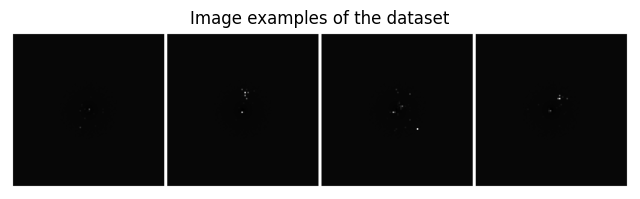

In [15]:
# Visualize some examples
NUM_IMAGES = 4
images = torch.stack([val_dataset[idx][0] for idx in range(NUM_IMAGES)], dim=0) #first is image indx, second is image/label/
img_grid = torchvision.utils.make_grid(images, nrow=4, normalize=True, pad_value=1.0)
img_grid = img_grid.permute(1, 2, 0) #move channel dim to the end as required in maptplotlib

plt.figure(figsize=(8,8))
plt.title("Image examples of the dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

## ViT architecture

Transformers have been originally proposed to process sets (un-ordered lists of items) since it is a permutation-equivariant architecture, i.e., producing the same output permuted if the input is permuted. 

To apply Transformers to sequences (ordered lists), we need to add a positional encoding to the input feature vectors. Hopefully the model will learn by itself how to use this additional information.

In this session we will work with images following the procedure proposed by Dosovitskiy et al.  in their paper "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale". 

Specifically, the Vision Transformer is a model for image classification that views images as sequences of smaller patches. 

As a preprocessing step, we need to divide the image in a sequence of small patches.

Each of those patches is considered to be a "word"/"token" and projected to a feature space. 

Then we will add a spatial encoding (additional paramenters that will encode the position of each patch in the larger image) to each patch. After this preprocessing we can apply a Transformer as usual to this sequence and start training it for our task.

Transformers can work with high resolution images and learn how to use context from very distant portion of the image.

Probably 25 patches of 20x20 pixels for such  images is not the best choice... you can try to optimize it!

In [18]:
# function to divide the input batch of images in a sequence of small patches

def img_to_patch(x, patch_size, flatten_channels=True):
    # flatten channels is more important as a parameter if we are working with multi channel images
    """
    Inputs:
        x - torch.Tensor representing the batch of images of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid. This is more important when working with 
                           multi channel images
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5) # [B, H', W', C, p_H, p_W]
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2,4)          # [B, H'*W', C*p_H*p_W]
    return x

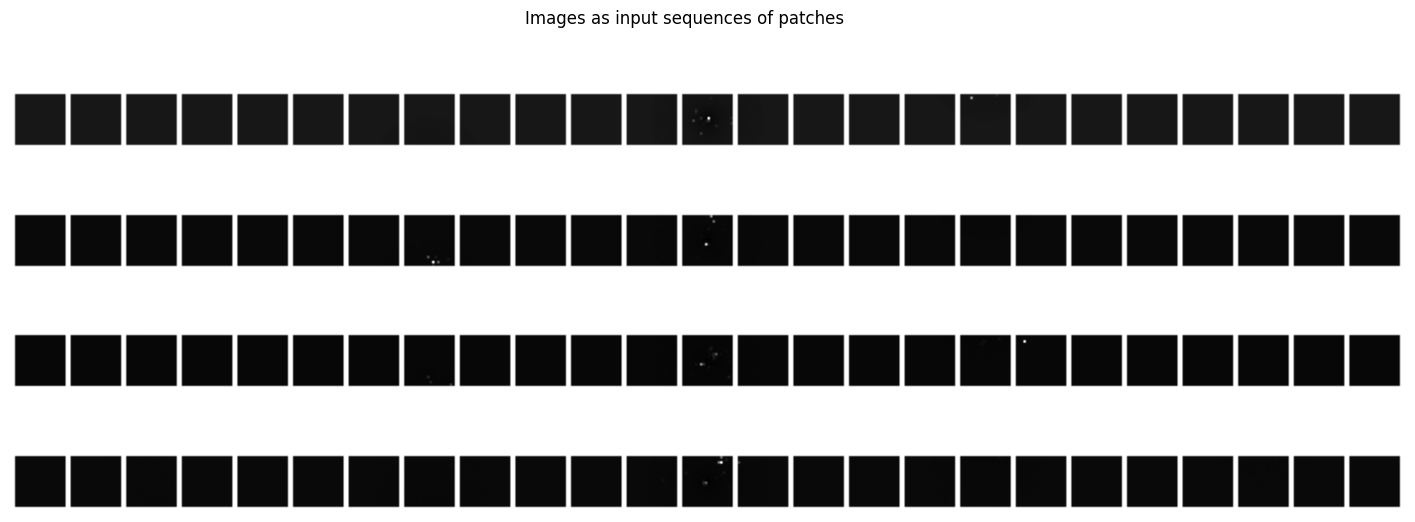

In [19]:
img_patches = img_to_patch(images, patch_size=20, flatten_channels=False)

fig, ax = plt.subplots(images.shape[0], 1, figsize=(18,6))
fig.suptitle("Images as input sequences of patches")
for i in range(images.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=64, normalize=True, pad_value=1)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis('off')
plt.show()
plt.close()

Compared to the original images, it is much harder to recognize the objects from those patch lists now. Still, this is the input we provide to the Transformer for classifying the images. The model has to learn itself how it has to combine the patches to recognize the objects. The inductive bias in CNNs that an image is a grid of pixels, is lost in this input format.

After we have looked at the preprocessing, we can now start building the Transformer model. 

 Further, we use the Pre-Layer Normalization version of the Transformer blocks proposed by Ruibin Xiong et al. in 2020. 
 
 The idea is to apply Layer Normalization not in between residual blocks, but instead as a first layer in the residual blocks. This reorganization of the layers supports better gradient flow and removes the necessity of a warm-up stage. 

In [20]:
class AttentionBlock(nn.Module):
    #  Implements the standard attention (multi-head attention + MLP) block for 
    #  a tranformer encoder architecture

    #  structure: 
    #   MHA: pre layer normalization (see Ruibin Xiong et al. (2020)) + multi-head attention (pytorch implementation) + layer normalization
    #   MLP: dense + gelu + droput + dense + dropout   

    #  arguments:
    #   embed_dim  - Dimensionality of input and attention feature vectors
    #   hidden_dim - Dimensionality of hidden layer in feed-forward network 
    #                (usually 2-4x larger than embed_dim)
    #   num_heads  - Number of heads to use in the Multi-Head Attention block
    #   dropout    - Amount of dropout to apply in the feed-forward network

    #    ^
    #    |_____    NOR2(x) + NOR2(MHA(NOR1(x))) + MLP(NOR2(MHA(NOR1(x)))): output (L,B,embde_dim)
    #    |     ^
    #  -----   |
    # | MLP |  |
    #  -----   |
    #    |_____|
    #    |     
    #  -----  
    # | NOR |  
    #  -----   
    #    |_____    x + MHA(NOR1(x))
    #    |     ^
    #  -----   |
    # | MHA |  |
    #  -----   |
    #    |     |
    #  -----   |
    # | NOR |  |
    #  -----   | 
    #    |_____|
    #    |        x    

    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        super(AttentionBlock, self).__init__()
        
        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads) #this pytroch function implements a full MH-Attention block (see https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )
          
    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0] #nn.MultiheadAttention expects input shapes 3x(L,B,F) and output 
        x = self.layer_norm_2(x)
        x = x + self.mlp(x)  
        return x   

Now we have all modules ready to build our own Vision Transformer. Besides the Transformer encoder, we need the following modules:

- A linear projection layer that maps the input patches to a feature vector of larger size. It is implemented by a simple linear layer that takes each patch independently as input.

- A classification token that is added to the input sequence. We will use the output feature vector of the classification token (CLS token in short) for determining the classification prediction.

- Learnable positional encodings that are added to the tokens before being processed by the Transformer. Those are needed to learn position-dependent information, and convert the set to a sequence. Since we usually work with a fixed resolution, we can learn the positional encodings instead of having the pattern of sine and cosine functions [Here you can find a good explanation of positional encodings for NLP sequences with varing length](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/).

- An MLP head that takes the output feature vector of the CLS token, and maps it to a classification prediction. This is usually implemented by a small feed-forward network or even a single linear layer.


Vision Transformer Architecture:


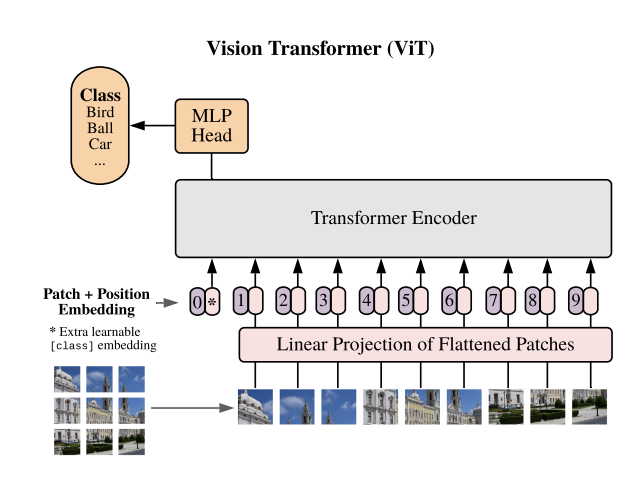

In [24]:
from IPython.display import Image
Image('http://giagu.web.cern.ch/giagu/CERN/ViT.png', width=500)

In [28]:
class VisionTransformer(nn.Module):
    #  Classifier based on a ViT  architecture implementation
    #  arguments:
    #   embed_dim  - Dimensionality of embedding in input fetaure vector to the Transformer
    #   hidden_dim - Dimensionality of hidden layer in feed-forward network 
    #   num_channels - Number of channels of the input (3 for RGB)
    #   num_heads  - Number of heads to use in the Multi-Head Attention block
    #   num_layers - Number of layers to use in the Transformer  
    #   patch_size - Number of pixels that the patches have per dimension
    #   num_patches - Maximum number of patches an image can have
    #   num_classes- Number of categories for the classification task
    #   dropout    - Amount of dropout to apply in the feed-forward network and in the input
    
    def __init__(self, embed_dim, hidden_dim, num_channels, num_heads, num_layers, patch_size, num_patches, num_classes, dropout=0.0):
        super(VisionTransformer, self).__init__()

        self.patch_size = patch_size
                
        # input layer (a dense layer projecting the input in a embed_dim embedding space)
        self.input_layer = nn.Linear(num_channels*(patch_size**2), embed_dim)

        # Transformer encoder: stack of num_layers Attention Blocks (embed_dim -> embed_dim)
        self.transformer = nn.Sequential(*[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers)])
        
        # MLP Classifier (embed_dim -> num_classes)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

        self.dropout = nn.Dropout(dropout)


        #parameters / embedding
        self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1,1+num_patches,embed_dim))# this is our positional  embedding. It is initialized as a random number but it is learnable so it will be optimized during training.
    
    
    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)
        
        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.pos_embedding[:,:T+1]
        
        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)
        
        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

In [29]:
# instantiate the model

# NOTE: embed_dim MUST be an integer multiple of num_heads
model_kwargs={
              'embed_dim': 64,
              'hidden_dim': 128,
              'num_heads': 8,
              'num_layers': 4,
              'patch_size': 20,
              'num_channels': 1,
              'num_patches': 25, 
              'num_classes': 5,
              'dropout': 0.30
             }

model = VisionTransformer(**model_kwargs)

In [32]:
# print model structure

print(model)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(1,100,100))
else:
  summary(model, input_size=(1,100,100))

VisionTransformer(
  (input_layer): Linear(in_features=400, out_features=64, bias=True)
  (transformer): Sequential(
    (0): AttentionBlock(
      (layer_norm_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (layer_norm_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=128, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.3, inplace=False)
        (3): Linear(in_features=128, out_features=64, bias=True)
        (4): Dropout(p=0.3, inplace=False)
      )
    )
    (1): AttentionBlock(
      (layer_norm_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (layer_norm_2): LayerNorm((64,), 

In [33]:
# test the model on one batch to check everything is ok before training it

model.to(device) #move the model on device (cpu/gpu)

xb,yb=next(iter(train_loader)) #take a mini batch from the trainign dataloader
xb=xb.type(torch.float).to(device) #move torch tensors to device (cpu or GPU)
yb=yb.type(torch.long).to(device)
print(xb.shape)
print(yb.shape)

out=model(xb) #apply the model on the input batch
print(out.shape)

torch.Size([256, 1, 100, 100])
torch.Size([256])
torch.Size([256, 5])


## Training Procedure

We are now ready to complete the model by defining the loss function, the accuracy metric to monitor the training of the classifier, and the optmizer + learning rate scheduler.

Write two simple procedures to train and test the model on the training and test dataset, respectively.

If you are not new to PyTorch, this scheme should appear familiar to you. Otherwise, the PyTorch web site provides [a good introduction on how to train a neural network in PyTorch](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-loss-function-and-optimizer).

In [34]:
#install torchmetrics: collection of useful PyTorch metrics implementations and an easy-to-use API to create custom metrics]
%pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 20.5 MB/s eta 0:00:00


In [35]:
#loss 
loss_func = nn.CrossEntropyLoss() #cross entropy loss

#metric accuracy from torchmetrics
import torchmetrics
from torchmetrics.classification import MulticlassAccuracy
metric_func = MulticlassAccuracy(num_classes=5)
metric_func = metric_func.to(device) 

# optimizer + lr schedular
from torch import optim
opt = optim.Adam(model.parameters(), lr=1e-3)

# scheduler for step decay lr schedule
lr_scheduler = optim.lr_scheduler.MultiStepLR(opt, milestones=[20,30,35], gamma=0.2)

In [36]:
#Checkpoints (to save model parameters during training)

# this is implemented by writing a python class that uses the torch.save method

class SaveBestModel:
    def __init__(self, best_valid_loss=float('inf')): #object initialized with best_loss = +infinite
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion, metric,
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            # method to save a model (the state_dict: a python dictionary object that 
            # maps each layer to its parameter tensor) and other useful parametrers
            # see: https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                'metric': metric,
                }, 'best_model.pth')

In [37]:
# in pytorch you are responsible of writing the training loop, this can be done by implementig specific 
# python functions for the training and validation steps, or just, like in this example, by using a simple plain
# python loop

#training loop

epochs = 40 #number of epochs (actually needs ~100 epochs with ~60-70k input examples)

import time

save_best_model = SaveBestModel() #initialize checkpoint function

# dfine python lists to save loss and metric history
hist_loss = []
hist_metric = []
hist_vloss = []
hist_vmetric = []

#loop over epochs
for epoch in range(epochs):
    t0 = time.time()

    #training step
    model.train()

    train_loss = 0.0
    train_metric = 0.0
    counter = 0
    for xb, yb in train_loader: #takes a batch from the train dataloader 
        counter += 1 
        xb=xb.type(torch.float).to(device) #move troch tensors to device (cpu or GPU)
        yb=yb.type(torch.long).to(device)
        
        pred = model(xb) #get prediction for batch
        loss = loss_func(pred, yb) #compute loss
        metric = metric_func(pred, yb) #compute accuracy

        train_loss += loss.item() #update total loss
        train_metric += metric.item() #update total metric
  
        # backpropagation
        loss.backward()
        # update weights
        opt.step()
        # set to zero gradients for the next step
        opt.zero_grad()
 
    # normalize loss and metric by number of batches
    train_loss = train_loss/(counter)
    train_metric = train_metric/(counter)

    # update history
    hist_loss.append(train_loss)
    hist_metric.append(train_metric)

    # evaluation step (same as training but w/o backpropagation)

    model.eval()

    vali_loss = 0.0
    vali_metric = 0.0
    counter = 0
    with torch.no_grad():
      for xb, yb in val_loader:
        counter += 1
        xb=xb.type(torch.float).to(device)
        yb=yb.type(torch.long).to(device)
        pred = model(xb)
        vloss = loss_func(pred, yb)
        vmetric = metric_func(pred, yb)
        vali_loss += vloss.item()
        vali_metric += vmetric.item()
        
    vali_loss = vali_loss/(counter) 
    vali_metric = vali_metric/(counter)   

    hist_vloss.append(vali_loss)
    hist_vmetric.append(vali_metric)

    #save best model
    save_best_model(vali_loss, epoch, model, opt, loss_func, metric_func)   

    elapsed_time = time.time()-t0
    current_lr = lr_scheduler.get_last_lr()[0]
    print("epoch: %d, time(s): %.2f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f,  lr : %1.2e" % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric,current_lr))

    # update learning rate schedule
    lr_scheduler.step()


Best validation loss: 1.2278812726338704

Saving best model for epoch: 1

epoch: 1, time(s): 26.53, train loss: 1.496078, train metric: 0.321346, vali loss: 1.227881, vali metric: 0.550828,  lr : 1.00e-03

Best validation loss: 1.0719307040174801

Saving best model for epoch: 2

epoch: 2, time(s): 21.28, train loss: 1.234499, train metric: 0.495559, vali loss: 1.071931, vali metric: 0.566366,  lr : 1.00e-03

Best validation loss: 1.0409446010986965

Saving best model for epoch: 3

epoch: 3, time(s): 20.76, train loss: 1.166044, train metric: 0.529577, vali loss: 1.040945, vali metric: 0.591885,  lr : 1.00e-03
epoch: 4, time(s): 21.95, train loss: 1.148268, train metric: 0.536072, vali loss: 1.045361, vali metric: 0.555396,  lr : 1.00e-03

Best validation loss: 1.0236439630389214

Saving best model for epoch: 5

epoch: 5, time(s): 22.32, train loss: 1.130623, train metric: 0.548105, vali loss: 1.023644, vali metric: 0.577383,  lr : 1.00e-03
epoch: 6, time(s): 21.09, train loss: 1.11878

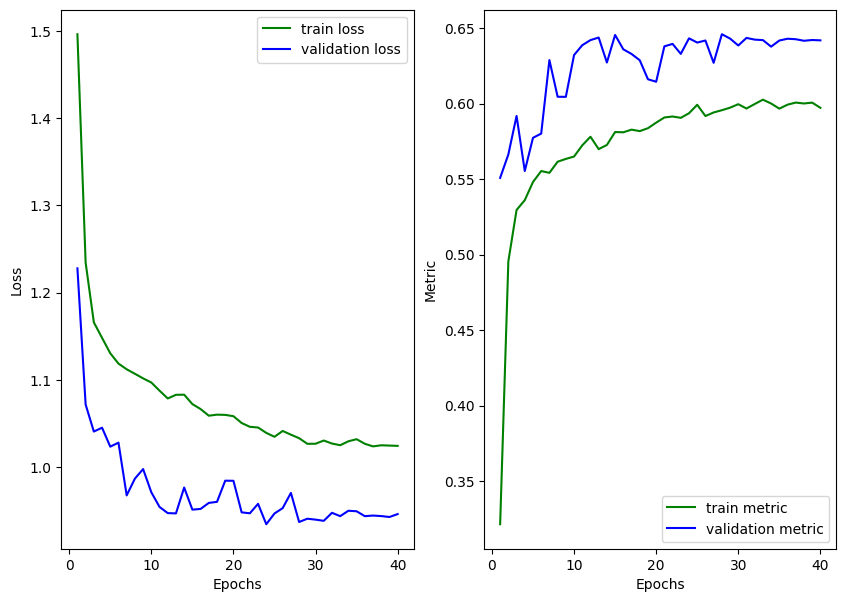

In [38]:
# plot training results (loss and accuracy vs epoch)

plt.figure(figsize=(10, 7))
plt.subplot(1,2,1)
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_vloss)+1), hist_vloss, color='blue', linestyle='-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1,len(hist_metric)+1), hist_metric,  color='green', linestyle='-', label='train metric')
plt.plot(range(1,len(hist_vmetric)+1),hist_vmetric, color='blue', linestyle='-', label='validation metric')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()

In [40]:
# load the best model
checkpoint = torch.load('./best_model.pth')
print('Best model at epoch: ', checkpoint['epoch'])

model = VisionTransformer(**model_kwargs)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval() 

Best model at epoch:  24


VisionTransformer(
  (input_layer): Linear(in_features=400, out_features=64, bias=True)
  (transformer): Sequential(
    (0): AttentionBlock(
      (layer_norm_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (layer_norm_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=128, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.3, inplace=False)
        (3): Linear(in_features=128, out_features=64, bias=True)
        (4): Dropout(p=0.3, inplace=False)
      )
    )
    (1): AttentionBlock(
      (layer_norm_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (layer_norm_2): LayerNorm((64,), 

In [41]:
# inference on test set
pred_prob = torch.empty(size=(0,5), device=device) #note the device parameter, this allows to create the torch tensors directly in the needed device
pred_val = torch.empty(size=(0,), device=device)
ground_truth = torch.empty(size=(0,), device=device)

model.to(device)

test_loss = 0.0
test_metric = 0.0

counter=0
with torch.no_grad():
  for xb, yb in test_loader:
    counter += 1
    xb=xb.type(torch.float).to(device)
    yb=yb.type(torch.long).to(device)
    res = model(xb)
    pre = torch.softmax(res, dim=1)
    val = pre.argmax(dim=1)  
    pred_prob = torch.cat((pred_prob, pre), dim=0)
    pred_val = torch.cat((pred_val, val), dim=0)
    ground_truth = torch.cat((ground_truth, yb), dim=0) 
    vloss = loss_func(res, yb)
    vmetric = metric_func(res, yb)
    test_loss += vloss.item()
    test_metric += vmetric.item()

test_loss = test_loss/(counter)
test_metric = test_metric/(counter) 

predict_val = pred_val.cpu().data.numpy()
predict_prob = pred_prob.cpu().data.numpy()
true_val = ground_truth.cpu().data.numpy()

print('test loss: ', test_loss)
print('test average accuracy: ', test_metric)

test loss:  0.9344410772124926
test average accuracy:  0.644811267654101


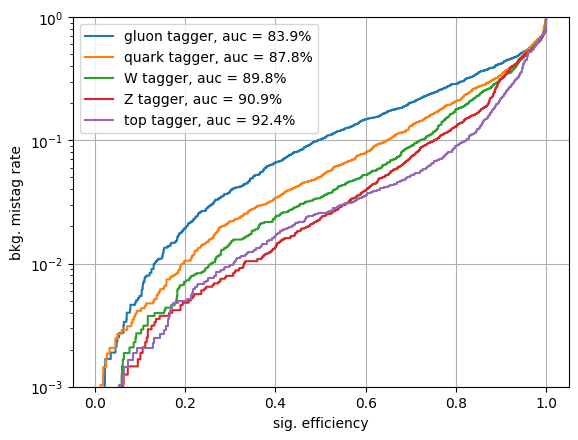

In [42]:
from sklearn.metrics import roc_curve, auc

# print ROC curves 
fpr = {}
tpr = {}
auc1 = {}
plt.figure()
for i, label in enumerate(labels):
        fpr[label], tpr[label], threshold = roc_curve((true_val==i), predict_prob[:,i])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.001,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

In [43]:
#function to print a formatted confusion matrix
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()

    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

In [44]:
# confusion matrix
from sklearn.metrics import confusion_matrix
c_mat = confusion_matrix(true_val, predict_val, normalize='true')
print("Confusion Matrix:")
print("")
print_cm(c_mat,labels)

Confusion Matrix:

          gluon quark     W     Z   top 
    gluon  0.59  0.18  0.03  0.03  0.18 
    quark  0.27  0.59  0.04  0.04  0.07 
        W  0.11  0.07  0.75  0.06  0.00 
        Z  0.10  0.06  0.28  0.54  0.01 
      top  0.16  0.00  0.06  0.03  0.75 
